In [1]:
import einops
import torch

from einops.layers.torch import EinMix

from utils.components import *
from utils.config import *
from utils.einmask import EinMask

from utils.masking import *

import itertools

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import entropy

In [3]:
from matplotlib.colors import LogNorm

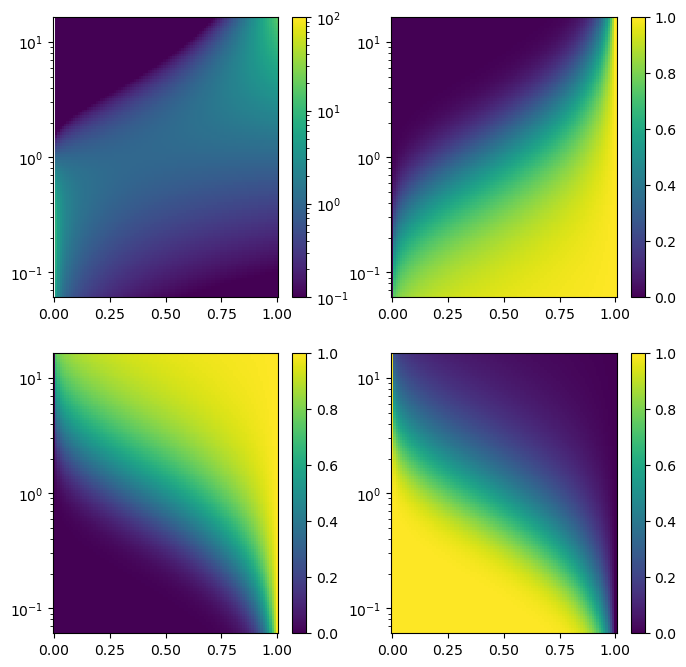

In [144]:
quantile_k = lambda u, a:  u.log().div(a).exp()
quantile_k1p = lambda u, a:  u.neg().log1p().div(a).exp()
g = lambda u: u.log().neg().log().neg()
pdf_k = lambda u, a: a * u.pow(a - 1)
cdf_k = lambda u, a: u.pow(a)

us = torch.linspace(0, 1, 100).view(1, -1)
cs = torch.logspace(-4, 4, 100, base=2).view(-1, 1)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.pcolormesh(us, cs, pdf_k(us, cs), norm=LogNorm(vmax= 100, vmin= 0.1))
plt.colorbar()
plt.yscale("log")
plt.subplot(222)
plt.pcolormesh(us, cs, cdf_k(us, cs))
plt.colorbar()
plt.yscale("log")
plt.subplot(223)
plt.pcolormesh(us, cs, quantile_k(us, cs))
plt.colorbar()
plt.yscale("log")
plt.subplot(224)
plt.pcolormesh(us, cs, 1 - quantile_k(us, cs))
plt.colorbar()
plt.yscale("log")

In [151]:
shapes = {'v': 9, 't': 12, 'h': 8, 'w': 16}
event_dims = {'v': 0.3, 't': 0.1}
size = list(shapes.values())
K = 100
b = 1000
N = prod(size)

def prior_fn(c: dict, sort: bool = True, invert_beta: bool = False, invert_factors: bool = False):
    lhs = ', '.join([f'b {d}' for d in c.keys()])
    rhs = 'b ' + ' '.join(d for d in c.keys())
    
    if invert_beta:
        factors = [quantile_k(1 - torch.rand(b, shapes[k]), v) for k, v in c.items()]
    elif invert_factors:
        factors = [1 - quantile_k(torch.rand(b, shapes[k]), v) for k, v in c.items()]
    else: 
        factors = [quantile_k(torch.rand(b, shapes[k]), v) for k, v in c.items()]
    if sort:
        factors = [f.sort(dim = -1, descending=False if invert_beta else True).values for f in factors]
    joint = einops.einsum(*factors, f'{lhs} -> {rhs}')
    joint = einops.repeat(joint, f'{rhs} -> b v t h w', **shapes)
    return joint

def multinomial_stats(joint: torch.Tensor):
    indices = torch.multinomial(joint.clamp(1e-9).flatten(1), K)
    coordinates = torch.unravel_index(indices, size)

    rs = [
        torch.stack([torch.bincount(batch, minlength=size[i]).div(K) for batch in events]).mean(0)
        for i, events in enumerate(coordinates)
        ]
    return rs


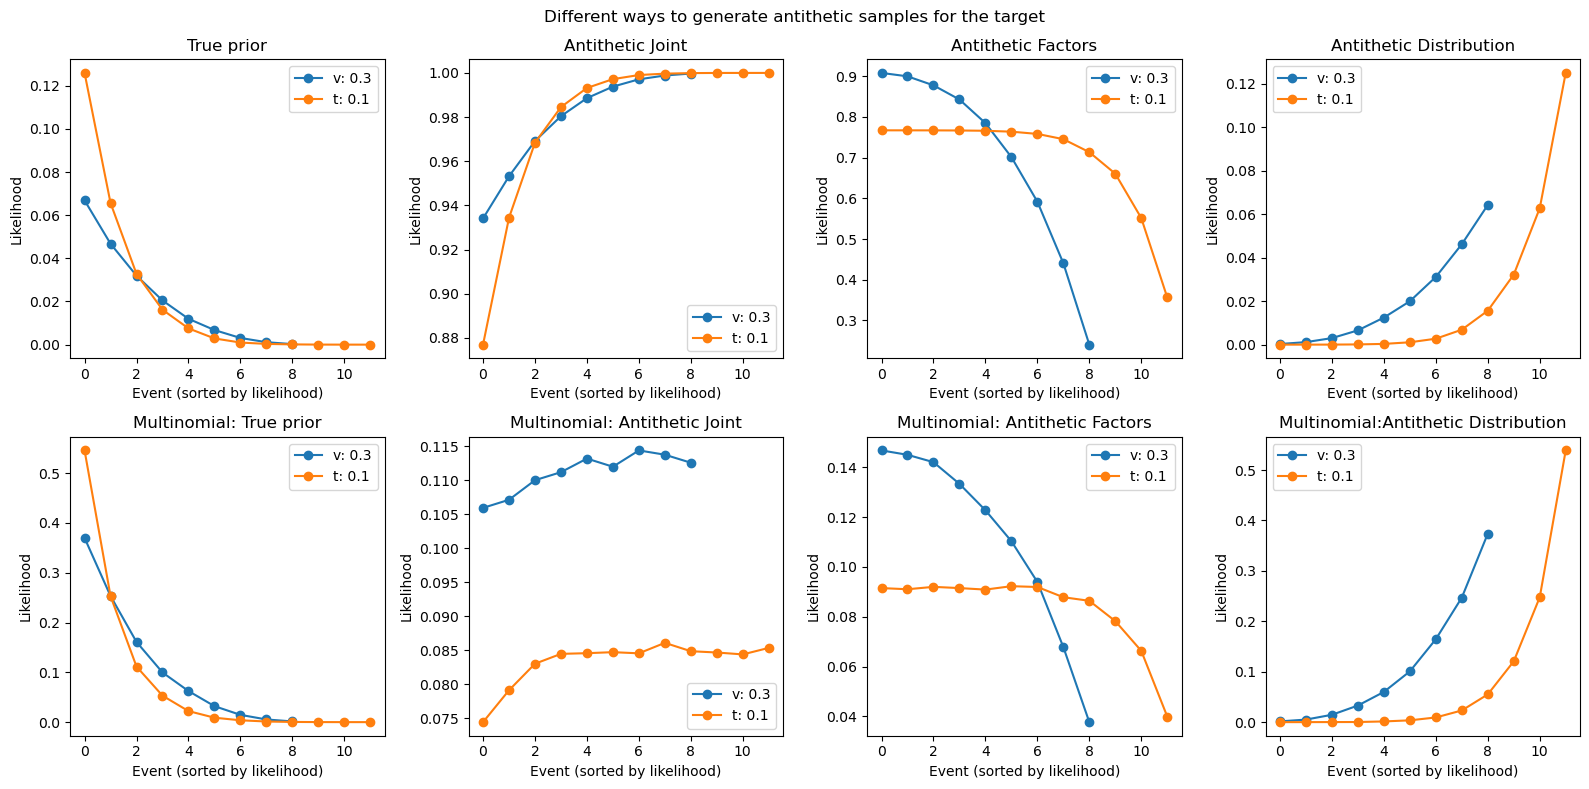

In [153]:

plt.figure(figsize=(16, 8))
plt.suptitle('Different ways to generate antithetic samples for the target')
plt.subplot(241)
joint = prior_fn(event_dims, sort=True)
for dim, param in event_dims.items():
    prior = einops.reduce(joint, f'b v t h w -> {dim}', reduction='mean')
    plt.plot(prior, 'o-', label = f'{dim}: {param}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("True prior")

plt.subplot(242)
joint = 1 - prior_fn(event_dims, sort=True)
for dim, param in event_dims.items():
    prior = einops.reduce(joint, f'b v t h w -> {dim}', reduction='mean')
    plt.plot(prior, 'o-', label = f'{dim}: {param}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Antithetic Joint")

plt.subplot(243)
joint = prior_fn(event_dims, sort=True, invert_factors= True)
for dim, param in event_dims.items():
    prior = einops.reduce(joint, f'b v t h w -> {dim}', reduction='mean')
    plt.plot(prior, 'o-', label = f'{dim}: {param}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Antithetic Factors")

plt.subplot(244)
joint = prior_fn(event_dims, sort=True, invert_beta=True)
for dim, param in event_dims.items():
    prior = einops.reduce(joint, f'b v t h w -> {dim}', reduction='mean')
    plt.plot(prior, 'o-', label = f'{dim}: {param}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Antithetic Distribution")

plt.subplot(245)
joint = prior_fn(event_dims, sort=True)
rs = multinomial_stats((joint))
for i, (k, v) in enumerate(event_dims.items()):
    plt.plot(rs[i], "o-", label = f'{k}: {v}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Multinomial: True prior")

plt.subplot(246)
joint = 1 - prior_fn(event_dims, sort=True)
rs = multinomial_stats((joint))
for i, (k, v) in enumerate(event_dims.items()):
    plt.plot(rs[i], "o-", label = f'{k}: {v}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Multinomial: Antithetic Joint")

plt.subplot(247)
joint = prior_fn(event_dims, sort=True, invert_factors= True)
rs = multinomial_stats((joint))
for i, (k, v) in enumerate(event_dims.items()):
    plt.plot(rs[i], "o-", label = f'{k}: {v}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Multinomial: Antithetic Factors")

plt.subplot(248)
joint =  prior_fn(event_dims, sort=True, invert_beta=True)
rs = multinomial_stats((joint))
for i, (k, v) in enumerate(event_dims.items()):
    plt.plot(rs[i], "o-", label = f'{k}: {v}')
plt.legend()
plt.xlabel('Event (sorted by likelihood)')
plt.ylabel('Likelihood')
plt.title("Multinomial:Antithetic Distribution")
plt.tight_layout()
plt.show()


In [ ]:
network = NetworkConfig(dim=512, num_latents=32, num_layers=12, num_tails=4, use_checkpoint=False, dim_in=256, dim_coords=64,
                        wavelengths=[(1,8),(1,8),(1,64),(1,128)])

In [ ]:
@dataclass
class NewObjectiveConfig:
    # event dims for prior
    event_dims: dict = field(default_factory=lambda: {})
    # integer multinomial bounds
    src_low: Optional[int] = None
    src_high: Optional[int] = None
    tgt_low: Optional[int] = None
    tgt_high: Optional[int] = None
    # schedule bounded [eps, 1-eps]
    epsilon: float = 1e-7
    # stratification
    stratify: Optional[bool] = False


In [ ]:

class MultinomialMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: NewObjectiveConfig):
        super().__init__()

        self.world = world
        self.objective = objective

        self.register_buffer('epsilon', torch.tensor(self.objective.epsilon))

    @property
    def device(self): return self.epsilon.device

    def uniform_(self, B: int, N: int, rng: torch.Generator):
        if self.objective.stratify:
            U = torch.rand(1, N, device = self.device, generator=rng)
            L = torch.linspace(0, 1, B, device= self.device).view(-1, 1)
            U = (U + L) % 1
        else:
            U = torch.rand(B, N, device = self.device, generator=rng)
        return U.clamp(self.epsilon, 1 - self.epsilon)
    
    def prior_(self, B: int, rng: torch.Generator = None):
        # baseline factors are constant
        F_src, F_tgt = torch.ones(2, B, self.world.num_tokens, device= self.device)

        # for each event dimension
        for dim, alpha in self.objective.event_dims.items():
            alpha = torch.as_tensor(alpha, device = self.device)

            # sample uniform variate along the dimension
            U = self.uniform_(B, self.world.token_sizes[dim], rng)

            # broadcast to the size of the full event space
            U = einops.repeat(U, f'b {dim} -> b {self.world.flat_token_pattern}', **self.world.token_sizes)

            # apply quantile function for Kumaraswamy(alpha, 1) and Kumaraswamy(1, alpha) and multiply factors
            F_src *= U.log().div(alpha).exp()
            F_tgt *= (1 - U).log().div(alpha).exp()

        return F_src.clamp(self.epsilon, 1 - self.epsilon), F_tgt.clamp(self.epsilon, 1 - self.epsilon)
    
    def rates_(self, rng: torch.Generator = None):
        src_bounds = default(self.objective.src_low, 1), default(self.objective.src_high, self.world.num_tokens)
        tgt_bounds = default(self.objective.tgt_low, 1), default(self.objective.tgt_high, self.world.num_tokens)
        K_src = torch.randint(*src_bounds, (1, ), generator= rng, device = self.device).item()
        K_tgt = torch.randint(*tgt_bounds, (1, ), generator= rng, device = self.device).item()
        return K_src, K_tgt
    
    def forward(self, B: int, rng: torch.Generator = None):
        B = B[0] if isinstance(B, tuple) else B

        # sample joint prior
        P_src, P_tgt = self.prior_(B, rng)

       # sample uniform rates from (low, high)
        K_src, K_tgt = self.rates_(rng)

        # sample multinomial 
        src_indices = torch.multinomial(P_src, K_src, generator=rng)
        tgt_indices = torch.multinomial(P_tgt, K_tgt, generator=rng)
        
        # create binary masks
        src_binary = torch.zeros_like(P_src, dtype= torch.bool).scatter_(1, src_indices, True)
        tgt_binary = torch.zeros_like(P_tgt, dtype= torch.bool).scatter_(1, tgt_indices, True)
        
        return src_indices, tgt_indices, tgt_binary, None
        
        

    

In [217]:
class HeuristicMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        # min/max rates
        self.src_min = objective.c0_src
        self.src_max = objective.c1_src
        self.tgt_min = objective.c0_tgt
        self.tgt_max = objective.c1_tgt

        self.c1_prior = objective.c1_prior

        # attributes
        self.k_min = default(objective.k_min, 1)
        self.k_max = default(objective.k_max, world.num_tokens // world.token_sizes['v'])

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.register_buffer('num_events', torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod())
        self.event_pattern = f'({" ".join(objective.event_dims)})'

    def forward(self, shape: tuple, rng: torch.Generator = None):
        u = torch.rand((2, *shape, self.num_events), generator = rng, device = self.num_events.device)
        p = torch.where(u[0] > self.c1_prior, u[1].clamp(0.1, 0.9), 1e-16)
        
        p = einops.repeat(p,
            f'... {self.event_pattern} -> ... (t h w)', 
            t = self.world.token_sizes['t'], h = self.world.token_sizes['h'], w = self.world.token_sizes['w']
            )

        rs = torch.rand((2, self.world.token_sizes['v']), generator = rng, device = self.num_events.device)
        r_src = self.src_min + (self.src_max - self.src_min) * rs[0]
        r_tgt = self.tgt_min + (self.tgt_max - self.tgt_min) * rs[1]

        src = torch.cat([torch.multinomial(p, int(r * self.k_max), generator=rng) + i * self.k_max for i, r in enumerate(r_src)], dim = -1)
        tgt = torch.cat([torch.multinomial(1 - p, int(r * self.k_max), generator=rng) + i * self.k_max for i, r in enumerate(r_tgt)], dim = -1)

        return src, tgt, None, None


In [218]:
class MultinomialMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.num_events = torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod()
        self.event_pattern = f'({" ".join(objective.event_dims)})'
        self.event_sizes = {d: world.token_sizes[d] for d in objective.event_dims}

        #schedule
        self.src_rates = StableKumaraswamy(c0=objective.c0_src, c1=objective.c1_src)
        self.tgt_rates = StableKumaraswamy(c0=objective.c0_tgt, c1=objective.c1_tgt)
        self.prior = StableKumaraswamy(c0= objective.c0_prior, c1= objective.c1_prior, epsilon=1e-2)
        
        # attributes
        self.k_min = default(objective.k_min, 2)
        self.k_max = default(objective.k_max, world.num_tokens)

    def expand_events(self, *args):
        return einops.repeat(
            [*args],
            f'args ... {self.event_pattern} -> args ... {self.world.flat_token_pattern}', 
            **self.world.token_sizes
            )
    
    def k_from_rates(self, r: float):
        return int(self.k_min + (self.k_max - self.k_min) * r)

    def _compute_event_weights(self, shape: tuple, rng: torch.Generator = None) -> torch.Tensor:
            """Generates factorized probability weights for source and target masking."""
            device = self.num_events.device
            
            # Generate independent factors for each event dimension
            dim_factors = [
                einops.repeat(
                    torch.rand((*shape, s), device=device, generator=rng),
                    f"... {d} -> ... {self.event_pattern}",
                    **self.event_sizes
                )
                for d, s in self.event_sizes.items()
            ]
            
            # Multiply factors to get joint probabilities
            # Source uses the factors directly; target uses the complements
            stacked_factors = torch.stack(dim_factors)
            src_weights = stacked_factors.prod(dim=0)
            tgt_weights = (1 - stacked_factors).prod(dim=0)
            
            return src_weights, tgt_weights

    def forward(self, shape: tuple, rng: torch.Generator = None):
        assert len(shape) == 1, "Currently only supports 1D batch shapes."
        
        src_w, tgt_w = self._compute_event_weights((1,) if self.objective.stratify else shape, rng)

        if self.objective.stratify:
            # Shift the base weights across the batch to ensure uniform coverage
            offsets = torch.linspace(0, 1, shape[0], device=src_w.device).view(-1, 1)
            src_w = (src_w + offsets) % 1
            tgt_w = (tgt_w + offsets) % 1

        src_probs, tgt_probs = self.expand_events(
             self.prior.quantile(src_w), self.prior.quantile(tgt_w)
             )

        k_src = self.k_from_rates(self.src_rates((1,), rng)[0])
        k_tgt = self.k_from_rates(self.tgt_rates((1,), rng)[0])

        src_indices = torch.multinomial(src_probs.clamp(1e-7), k_src, generator=rng)
        tgt_indices = torch.multinomial(tgt_probs.clamp(1e-7), k_tgt, generator=rng)

        tgt_binary = torch.zeros_like(src_probs, dtype= torch.bool).scatter_(1, tgt_indices, True)

        return src_indices, tgt_indices, tgt_binary, None

In [219]:
world = WorldConfig(field_sizes={"v": 9, "t": 36, "h": 64, "w": 120}, patch_sizes={'vv': 1, 'tt': 6, 'hh': 8, 'ww': 8}, batch_size=1)
print(world.num_tokens)
hm = HeuristicMasking(world, objective=ObjectiveConfig( c1_prior=0.2, 
                                                       c1_src= 2048 / world.num_tokens, c0_src=192/ world.num_tokens, 
                                                       c1_tgt=4096/world.num_tokens, c0_tgt=2048/world.num_tokens))


event_id = 1
T = world.token_shape[event_id]
N = world.num_tokens // T
srcs, tgts = [], []
#overlap = []
for _ in range(1000):
    src, tgt, _, _ = hm((1,))
    sm = torch.unravel_index(src, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
    tm = torch.unravel_index(tgt, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
    srcs.append(sm)
    #overlap.append(len({x for x in src.squeeze()}.intersection({x for x in tgt.squeeze()})))
    tgts.append(tm)
srcs = torch.stack(srcs)
tgts = torch.stack(tgts)
#print(sum(overlap)/1000)
rsrc_hm = srcs.sort(dim=1, descending=True).values
rtgt_hm = tgts.sort(dim=1, descending=False).values

6480


In [223]:
2048/world.num_tokens

0.3160493827160494

In [220]:
mm = MultinomialMasking(world, 
                        objective=ObjectiveConfig(c1_prior= 0.3, c0_prior= 1,    
                                                  c1_src= 1, c0_src=4, c1_tgt=4, c0_tgt=16,
                                                  event_dims=['t', 'v'], stratify=True))
print(mm.prior.c1)

tensor(0.3000)


In [222]:


mm = Masking(world, NewObjectiveConfig({'v': 1., 't': 0.2}, src_low = 1024, src_high= 4096, tgt_low = 2048, tgt_high = 8192, epsilon=1e-9))
srcs, tgts = [], []
misc = []
for _ in range(1000):
    src, tgt, _, _ = mm((1,))
    src, tgt = src.squeeze(0), tgt.squeeze(0)
    sm = torch.unravel_index(src, world.token_shape)[event_id].bincount(minlength=T) / N
    tm = torch.unravel_index(tgt, world.token_shape)[event_id].bincount(minlength=T) / N
    srcs.append(sm)
    tgts.append(tm)
    #misc.append(md4.squeeze())

srcs = torch.stack(srcs)
tgts = torch.stack(tgts)
#misc = torch.stack(misc)

rsrc_mm = srcs.sort(dim=1, descending=True).values
rtgt_mm = tgts.sort(dim=1, descending=False).values

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.errorbar(x = torch.arange(T), y = rsrc_hm.mean(dim=0), yerr=rsrc_hm.std(dim=0), fmt='x-', label='Src V1', alpha=0.7)
plt.errorbar(x = torch.arange(T), y = rtgt_hm.mean(dim=0), yerr=rtgt_hm.std(dim=0), fmt='x-', label=' Tgt V1', alpha=0.7)
plt.hlines(0.01, 0, T - 1, colors='red', linestyles='dashed')

plt.errorbar(x = torch.arange(T), y = rsrc_mm.mean(dim=0), yerr=rsrc_mm.std(dim=0), fmt='o-', label='Src V2', alpha=0.7)
plt.errorbar(x = torch.arange(T), y = rtgt_mm.mean(dim=0), yerr=rtgt_mm.std(dim=0), fmt='o-', label=' Tgt V2', alpha=0.7)

plt.ylabel('Expected visibility rate')
plt.xticks(ticks= torch.arange(T), labels= [f' {i+1}' for i in range(T)])
plt.xlabel('Event index (sorted)')
plt.legend()
plt.hlines(1, 0, T - 1, colors='red', linestyles='dashed')

plt.subplot(122)
plt.plot((rsrc_hm == 0).sum(1).bincount(minlength=T + 1) / 10, 'x-',alpha = 0.7, label = 'src H')
plt.plot((rtgt_hm == 0).sum(1).bincount(minlength=T + 1) / 10, 'x-',alpha = 0.7, label = 'tgt H')
plt.plot((rsrc_mm == 0).sum(1).bincount(minlength=T + 1) / 10, 'o-',alpha = 0.7, label = 'src K')
plt.plot((rtgt_mm == 0).sum(1).bincount(minlength=T + 1) / 10, 'o-',alpha = 0.7, label = 'tgt K')
plt.legend()
plt.xlabel('# dropped per sample')
plt.hlines(0.01, 0, T - 1, colors='red', linestyles='dashed')
plt.ylabel('pct')

RuntimeError: cannot sample n_sample > prob_dist.size(-1) samples without replacement

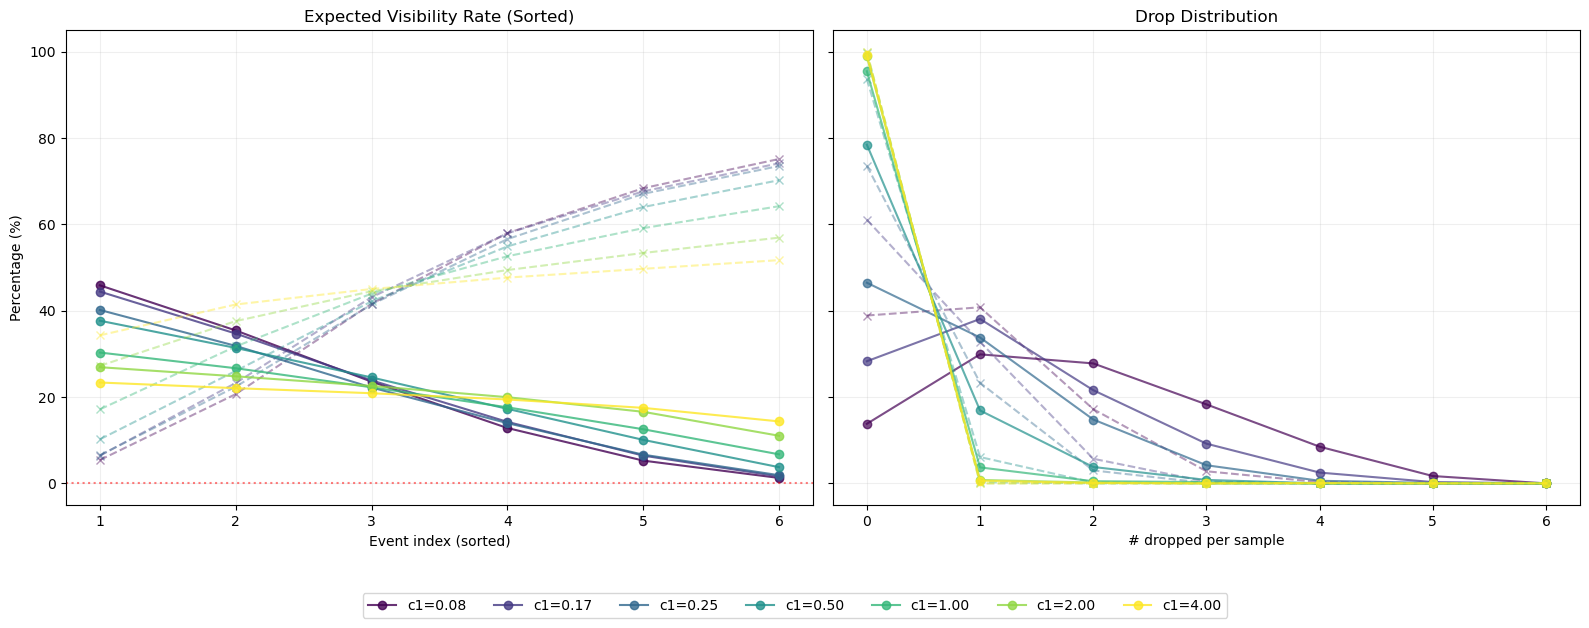

In [ ]:

# Configuration
world = WorldConfig(field_sizes={"v": 9, "t": 36, "h": 64, "w": 120}, 
                    patch_sizes={'vv': 1, 'tt': 6, 'hh': 8, 'ww': 8}, 
                    batch_size=1)

event_id = 1
T = world.token_shape[event_id]
N = world.num_tokens // T
num_samples = 1000

c1_values = [1/12, 1/6, 1/4, 1/2, 1., 2., 4]
colors = cm.viridis(torch.linspace(0, 1, len(c1_values)))

# Set sharey=True so both plots use the same Y-axis scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# To store handles for a single legend
legend_handles = []

for i, c1_val in enumerate(c1_values):
    mm = MultinomialMasking(
        world, 
        objective=ObjectiveConfig(
            c1_prior=c1_val, 
            c0_prior=1,    
            c1_src=1, c0_src=4, 
            c1_tgt=4, c0_tgt=16,
            event_dims=['t', 'v'], 
            stratify=True
        )
    )
    
    srcs, tgts = [], []
    for _ in range(num_samples):
        src, tgt, _, _ = mm((1,))
        sm = torch.unravel_index(src, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
        tm = torch.unravel_index(tgt, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
        srcs.append(sm)
        tgts.append(tm)

    srcs = torch.stack(srcs)
    tgts = torch.stack(tgts)

    rsrc_mm = srcs.sort(dim=1, descending=True).values
    rtgt_mm = tgts.sort(dim=1, descending=False).values

    # --- Subplot 1: Visibility Rates ---
    l1, = ax1.plot(torch.arange(T), rsrc_mm.mean(dim=0) * 100, 'o-', color=colors[i], alpha=0.8)
    ax1.plot(torch.arange(T), rtgt_mm.mean(dim=0) * 100, 'x--', color=colors[i], alpha=0.4)

    # --- Subplot 2: Drop Distribution ---
    src_dropped = (srcs == 0).sum(1).bincount(minlength=T + 1) / (num_samples / 100)
    tgt_dropped = (tgts == 0).sum(1).bincount(minlength=T + 1) / (num_samples / 100)
    
    ax2.plot(src_dropped, 'o-', color=colors[i], alpha=0.7)
    ax2.plot(tgt_dropped, 'x--', color=colors[i], alpha=0.4)
    
    # Store one handle per c1 value for the shared legend
    legend_handles.append(l1)

# Formatting Subplot 1
ax1.set_title('Expected Visibility Rate per Event')
ax1.set_xlabel('Event index (sorted)')
ax1.set_ylabel('Percentage (%)')
ax1.axhline(0, color='red', linestyle=':', alpha=0.5)
ax1.set_xticks(torch.arange(T))
ax1.set_xticklabels([f'{i+1}' for i in range(T)])
ax1.grid(alpha=0.2)

# Formatting Subplot 2
ax2.set_title('Drop Distribution')
ax2.set_xlabel('# dropped per sample')
ax2.grid(alpha=0.2)

# Create a single shared legend at the bottom
fig.legend(legend_handles, [f'c1={v:.2f}' for v in c1_values], 
           loc='lower center', ncol=len(c1_values), bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
# Adjust layout to make room for the bottom legend
plt.subplots_adjust(bottom=0.15)
plt.savefig('multinomial_drop_rates.png')
plt.show()

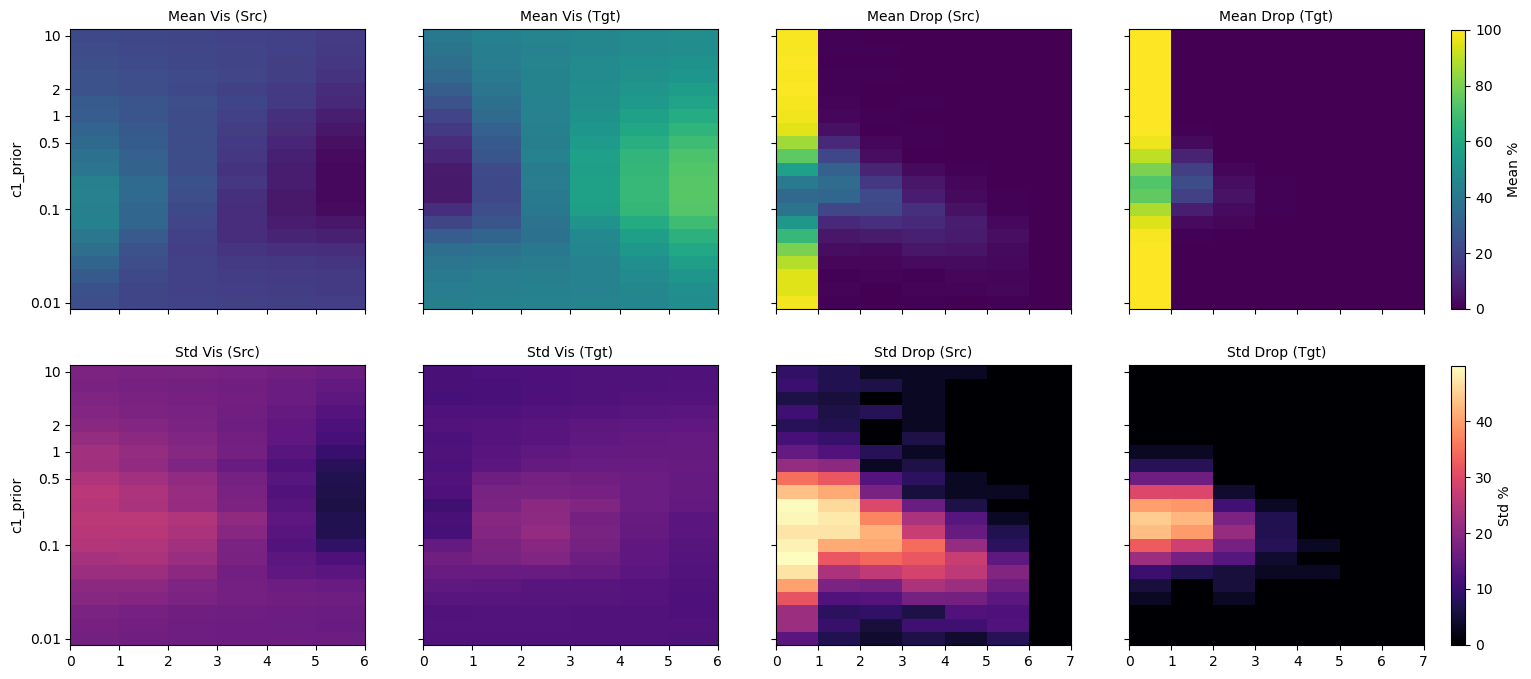

In [303]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

world = WorldConfig(field_sizes={"v": 9, "t": 36, "h": 64, "w": 120}, 
                    patch_sizes={'vv': 1, 'tt': 6, 'hh': 8, 'ww': 8}, 
                    batch_size=1)

event_id = 1
T = world.token_shape[event_id]
N = world.num_tokens // T
num_samples = 1000
c1_values = 10**torch.linspace(-2, 1, 21)

vis_mean_src, vis_std_src = torch.zeros(len(c1_values), T), torch.zeros(len(c1_values), T)
vis_mean_tgt, vis_std_tgt = torch.zeros(len(c1_values), T), torch.zeros(len(c1_values), T)
drop_mean_src, drop_std_src = torch.zeros(len(c1_values), T + 1), torch.zeros(len(c1_values), T + 1)
drop_mean_tgt, drop_std_tgt = torch.zeros(len(c1_values), T + 1), torch.zeros(len(c1_values), T + 1)

for i, c1_val in enumerate(c1_values):
    mm = MultinomialMasking(world, objective=ObjectiveConfig(
        c1_prior=c1_val, c0_prior=1, c1_src=1, c0_src=4, 
        c1_tgt=4, c0_tgt=16, event_dims=['t', 'v'], stratify=True))
    
    srcs, tgts = [], []
    for _ in range(num_samples):
        src, tgt, _, _ = mm((1,))
        sm = torch.unravel_index(src, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
        tm = torch.unravel_index(tgt, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
        srcs.append(sm)
        tgts.append(tm)

    srcs, tgts = torch.stack(srcs), torch.stack(tgts)
    ssrc, stgt = srcs.sort(dim=1, descending=True).values, tgts.sort(dim=1, descending=False).values
    
    vis_mean_src[i], vis_std_src[i] = ssrc.mean(0) * 100, ssrc.std(0) * 100
    vis_mean_tgt[i], vis_std_tgt[i] = stgt.mean(0) * 100, stgt.std(0) * 100
    
    def get_stats(tensor):
        counts = (tensor == 0).sum(1).float()
        dist = torch.stack([(counts == k).float() for k in range(T + 1)]).T 
        return dist.mean(0) * 100, dist.std(0) * 100

    drop_mean_src[i], drop_std_src[i] = get_stats(srcs)
    drop_mean_tgt[i], drop_std_tgt[i] = get_stats(tgts)

fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex='col', sharey='row')
yticks = [0.01, 0.1, 0.5, 1, 2, 10]
tick_idx = torch.searchsorted(c1_values, torch.tensor(yticks)).numpy()

vmax_mean = max(vis_mean_src.max(), vis_mean_tgt.max(), drop_mean_src.max(), drop_mean_tgt.max())
vmax_std = max(vis_std_src.max(), vis_std_tgt.max(), drop_std_src.max(), drop_std_src.max())

def plot_mesh(ax, data, title, cmap, vmax):
    im = ax.pcolormesh(data.numpy(), cmap=cmap, vmin=0, vmax=vmax)
    ax.set_title(title, fontsize=10)
    if ax in axes[:, 0]:
        ax.set_yticks(tick_idx + 0.5)
        ax.set_yticklabels([f'{y}' for y in yticks])
    return im

imgs_mean = [
    plot_mesh(axes[0,0], vis_mean_src, "Mean Vis (Src)", "viridis", vmax_mean),
    plot_mesh(axes[0,1], vis_mean_tgt, "Mean Vis (Tgt)", "viridis", vmax_mean),
    plot_mesh(axes[0,2], drop_mean_src, "Mean Drop (Src)", "viridis", vmax_mean),
    plot_mesh(axes[0,3], drop_mean_tgt, "Mean Drop (Tgt)", "viridis", vmax_mean)
]

imgs_std = [
    plot_mesh(axes[1,0], vis_std_src, "Std Vis (Src)", "magma", vmax_std),
    plot_mesh(axes[1,1], vis_std_tgt, "Std Vis (Tgt)", "magma", vmax_std),
    plot_mesh(axes[1,2], drop_std_src, "Std Drop (Src)", "magma", vmax_std),
    plot_mesh(axes[1,3], drop_std_tgt, "Std Drop (Tgt)", "magma", vmax_std)
]

fig.colorbar(imgs_mean[0], ax=axes[0, :], location='right', label='Mean %', fraction=0.01, pad=0.02)
fig.colorbar(imgs_std[0], ax=axes[1, :], location='right', label='Std %', fraction=0.01, pad=0.02)

axes[0,0].set_ylabel("c1_prior")
axes[1,0].set_ylabel("c1_prior")
plt.show()

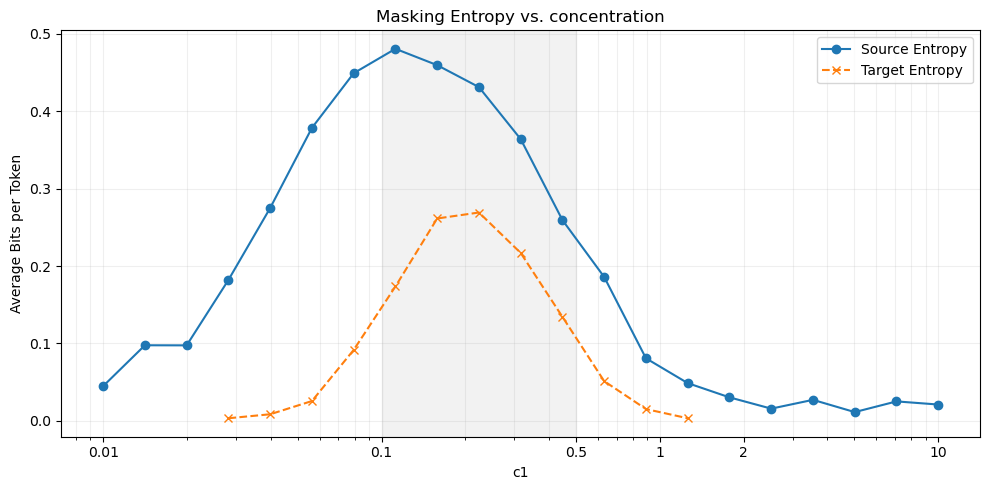

In [308]:
import torch.nn.functional as F

def calculate_entropy(prob_matrix):
    p = torch.clamp(prob_matrix / 100.0, 1e-9, 1-1e-9)
    # Binary Shannon entropy: -p log2(p) - (1-p) log2(1-p)
    return -(p * torch.log2(p) + (1 - p) * torch.log2(1 - p))

ent_src = calculate_entropy(drop_mean_src).mean(dim=1)
ent_tgt = calculate_entropy(drop_mean_tgt).mean(dim=1)

plt.figure(figsize=(10, 5))
plt.plot(c1_values, ent_src, 'o-', label='Source Entropy', color='#1f77b4')
plt.plot(c1_values, ent_tgt, 'x--', label='Target Entropy', color='#ff7f0e')

plt.xscale('log')
plt.xlabel('c1')
plt.ylabel('Average Bits per Token')
plt.title('Masking Entropy vs. concentration')
plt.xticks(yticks, [f'{y}' for y in yticks])
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

plt.axvspan(0.1, 0.5, color='gray', alpha=0.1)

plt.tight_layout()
plt.show()

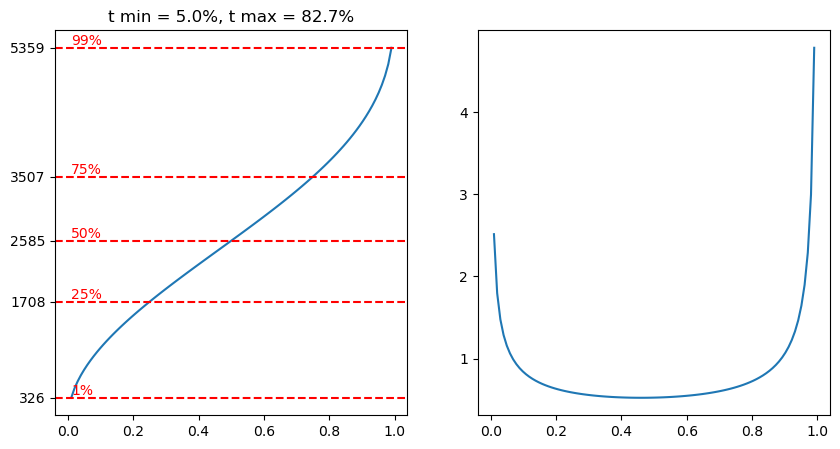

In [10]:
eps = 1e-2
u = torch.linspace(eps, 1 - eps,101)
c1 = 2
c0 = 4

k_min = 1
k_max = world.num_tokens
km = StableKumaraswamy(c1=c1, c0=c0)
t = km.quantile(u)
t = k_min + (k_max - k_min) * t
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(u, t)
plt.title(f"t min = {100*t.min().item()/k_max:.1f}%, t max = {100*t.max().item()/k_max:.1f}%")
# add quantile lines
qtls = [u.min().item(), 0.25, 0.5, 0.75, u.max().item()]
for q in qtls:
    uq = torch.tensor(q).unsqueeze(0)
    tq = km.quantile(uq)
    tq = k_min + (k_max - k_min) * tq
    plt.axhline(tq.item(), color='red', linestyle='--')
    plt.text(0.01, tq.item(), f"{q*100:.0f}%", color='red', va='bottom')
# add tick marks on y axis at quantiles
plt.yticks([k_min + (k_max - k_min) * km.quantile(torch.tensor(q).unsqueeze(0)).item() for q in qtls])
plt.subplot(1,2,2)
plt.plot(u, km.quantile_dt(u))


In [402]:
2**-4

0.0625

In [469]:
u = torch.linspace(1e-3,1 - 1e-3,1000)
up = torch.full((1000,), 0.99)
down = torch.full((1000,), 0.01)
cs = torch.logspace(-5, 2., 200, base = 2)

u_ticks = torch.tensor([0., 0.25, 0.5, 0.75, 1.0])
u_labels = [f'{t:.2f}' for t in u_ticks]
u_indices = torch.searchsorted(u, u_ticks)
c_ticks = torch.tensor([0.05, 0.1, 0.5, 1., 2.])
c_labels = [f'{t:.2f}' for t in c_ticks]
c_indices = torch.searchsorted(cs, c_ticks)

binary_entropy = lambda p: - (p * torch.log2(p+ 1e-9) + (1 - p) * torch.log2(1 - p + 1e-9))
binary_kl = lambda p,q: torch.log2((1 - p) / (1 - q) + 1e-9) + p * torch.log2((p - p * q) / (q - p * q) + 1e-9)
binary_jsd = lambda p, q: 0.5 * binary_kl(p, (p + q) / 2) + 0.5 * binary_kl(q, (p + q) / 2)
logits = lambda p: -torch.log2(p / (1 - p) + 1e-9)
sensitivity = lambda t: torch.abs(torch.gradient(t, spacing=(cs.log(), torch.ones_like(u)))[0])


rates = torch.stack([StableKumaraswamy(c1=c1, c0=1).quantile(u).clamp(1e-6, 1 - 1e-6) for c1 in cs])
tail_rates = torch.logical_or(rates[..., None].lt(down), rates[..., None].gt(up)).float().mean(1)

jsd = binary_jsd(rates, tail_rates)

<a list of 4 text.Text objects>

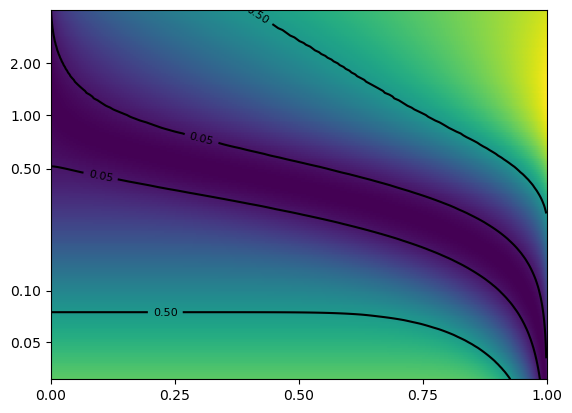

In [446]:
plt.pcolormesh(jsd)
lev = [0.05, 0.5, 1]
c = plt.contour(jsd, levels = lev, colors = 'black')
plt.yticks(c_indices, c_labels)
plt.xticks(u_indices, u_labels)
plt.clabel(c, fmt={l: f'{l:.2f}' for l in lev}, inline=True, fontsize=8)

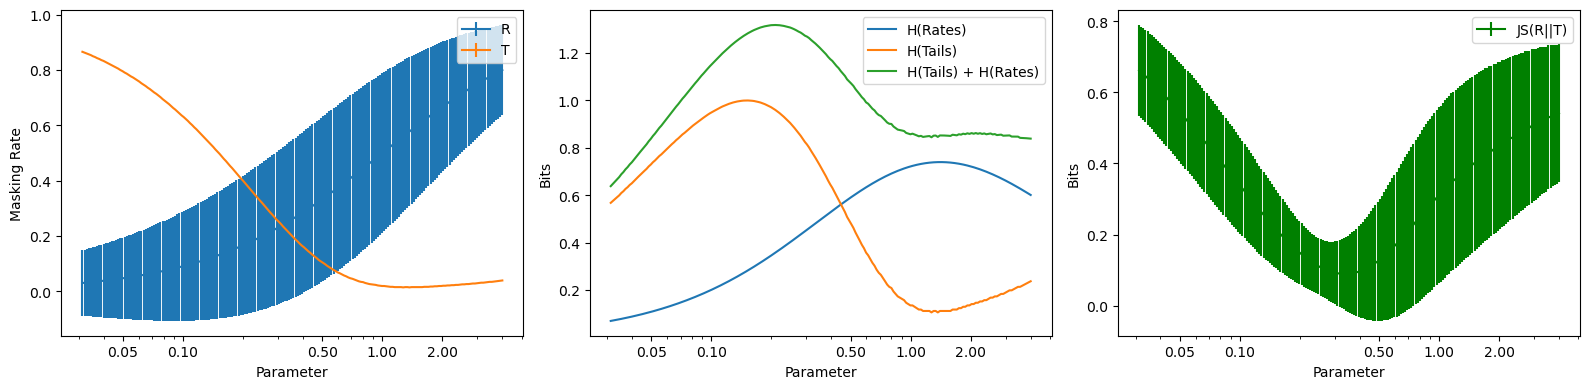

In [447]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.errorbar(cs, rates.mean(1), rates.std(1), label = 'R')
plt.errorbar(cs, tail_rates.mean(1), tail_rates.std(1), label = 'T')
plt.xscale('log')
plt.xticks(c_ticks, c_labels)
plt.ylabel('Masking Rate')
plt.xlabel('Parameter')
plt.legend()

plt.subplot(132)
plt.plot(cs, binary_entropy(rates).mean(1), label = 'H(Rates)')
plt.plot(cs, binary_entropy(tail_rates).mean(1), label = 'H(Tails)')
plt.plot(cs, (binary_entropy(rates) + binary_entropy(tail_rates)).mean(1), label = 'H(Tails) + H(Rates)')
plt.ylabel('Bits')
plt.xlabel('Parameter')
plt.xscale('log')
plt.xticks(c_ticks, c_labels)
plt.legend()

plt.subplot(133)
plt.errorbar(cs, jsd.mean(1), jsd.std(1), label = 'JS(R||T)', color = 'green')
plt.legend()
plt.ylabel('Bits')
plt.xlabel('Parameter')
plt.xscale('log')
plt.xticks(c_ticks, c_labels)
plt.tight_layout()
plt.show()

In [478]:
jsmin = cs[jsd.mean(1).argmin()], jsd.mean(1).min()
h_mix = (binary_entropy(rates) + binary_entropy(tail_rates)).mean(1)
h_mix_max = cs[h_mix.argmax()], h_mix.max()

s_tail = sensitivity(tail_rates).mean(1)
s_tail_max = cs[s_tail.argmax()], s_tail.max()

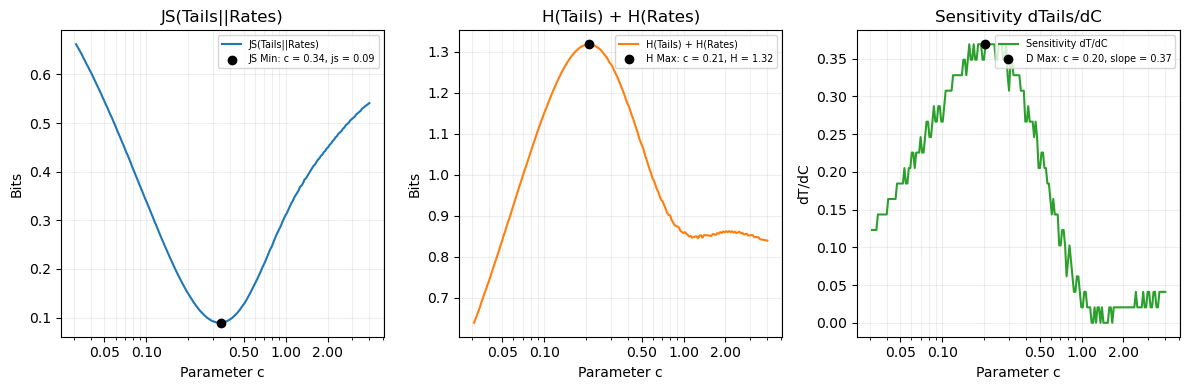

In [480]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].semilogx(cs, jsd.mean(1), label='JS(Tails||Rates)', color='tab:blue')
axes[0].scatter(*jsmin, color='black', zorder=5,
               label=f'JS Min: c = {jsmin[0].item():.2f}, js = {jsmin[1].item():.2f}')
axes[0].set_ylabel('Bits')
axes[0].set_title('JS(Tails||Rates)')

axes[1].semilogx(cs, h_mix, label='H(Tails) + H(Rates)', color='tab:orange')
axes[1].scatter(*h_mix_max, color='black', zorder=5,
               label=f'H Max: c = {h_mix_max[0].item():.2f}, H = {h_mix_max[1].item():.2f}')
axes[1].set_title('H(Tails) + H(Rates)')
axes[1].set_ylabel('Bits')

axes[2].semilogx(cs, s_tail, label='Sensitivity dT/dC', color='tab:green')
axes[2].scatter(*s_tail_max, color='black', zorder=5,
               label=f'D Max: c = {s_tail_max[0].item():.2f}, slope = {s_tail_max[1].item():.2f}')
axes[2].set_title('Sensitivity dTails/dC')
axes[2].set_ylabel('dT/dC')

for ax in axes:
    ax.set_xticks(c_ticks)
    ax.set_xticklabels(c_labels)
    ax.set_xlabel('Parameter c')
    ax.legend(loc='upper right', fontsize='x-small')
    ax.grid(True, which="both", ls="-", alpha=0.2) 

plt.tight_layout()
plt.show()

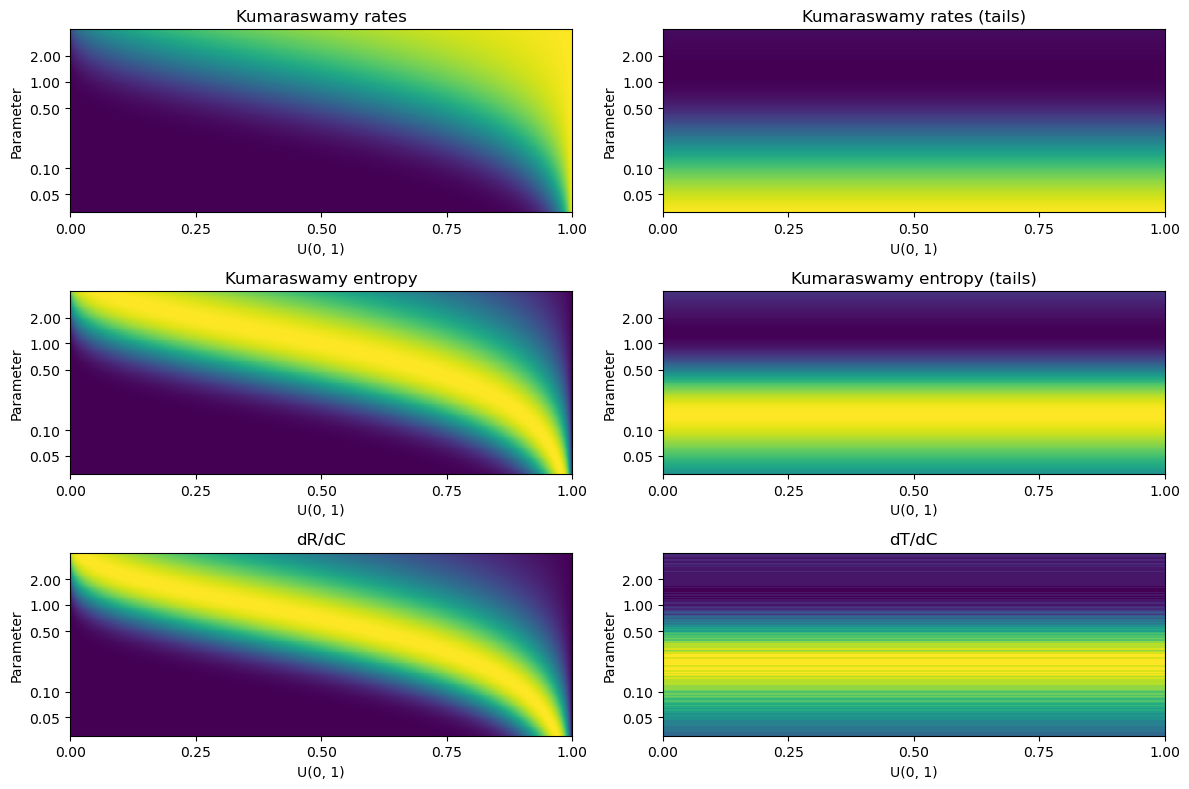

In [450]:
plt.figure(figsize=(12, 8))
plt.subplot(321)
plt.pcolormesh(rates)
plt.ylabel('Parameter')
plt.xlabel('U(0, 1)')
plt.xticks(u_indices, u_labels)
plt.yticks(c_indices, c_labels)
plt.title('Kumaraswamy rates')
plt.subplot(323)
plt.pcolormesh(binary_entropy(rates))
plt.ylabel('Parameter')
plt.xlabel('U(0, 1)')
plt.xticks(u_indices, u_labels)
plt.yticks(c_indices, c_labels)
plt.title('Kumaraswamy entropy')
plt.subplot(322)
plt.pcolormesh(tail_rates)
plt.ylabel('Parameter')
plt.xlabel('U(0, 1)')
plt.xticks(u_indices, u_labels)
plt.yticks(c_indices, c_labels)
plt.title('Kumaraswamy rates (tails)')
plt.subplot(324)
plt.pcolormesh(binary_entropy(tail_rates))
plt.ylabel('Parameter')
plt.xlabel('U(0, 1)')
plt.xticks(u_indices, u_labels)
plt.yticks(c_indices, c_labels)
plt.title('Kumaraswamy entropy (tails)')
plt.subplot(325)
plt.pcolormesh(sensitivity(rates))
plt.ylabel('Parameter')
plt.xlabel('U(0, 1)')
plt.xticks(u_indices, u_labels)
plt.yticks(c_indices, c_labels)
plt.title('dR/dC')
plt.subplot(326)
plt.pcolormesh(sensitivity(tail_rates))
plt.ylabel('Parameter')
plt.xlabel('U(0, 1)')
plt.xticks(u_indices, u_labels)
plt.yticks(c_indices, c_labels)
plt.title('dT/dC')
plt.tight_layout()

TypeError: Invalid shape (1000,) for image data

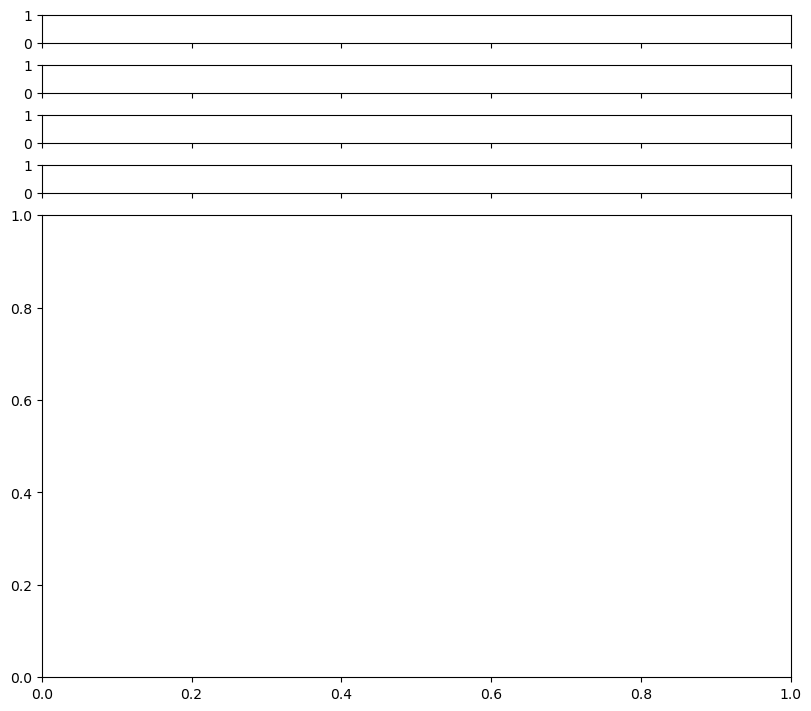

In [407]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
cs = 10**torch.linspace(-2,2,100)
u1, u2 = torch.meshgrid([u]*2, indexing='ij')
masks = torch.stack([u1 > StableKumaraswamy(c1=c1, c0=1).quantile(u2) for c1 in cs])
rates= entropy(masks.float().mean(1))

r_cos = torch.cos((torch.pi / 2) * u2).mean(0, keepdim=True)
r_lin = (1 - u2).mean(0, keepdim=True)
p = 0.1
r_h = (1 - torch.where(u2 > p, (u2 - p) / (1 - p) , 0)).mean(0, keepdim=True)
r_k = (u1 > StableKumaraswamy(c1=0.16, c0=1).quantile(u2)).float().mean(0, keepdim=True)
# List of schedules to plot as bars
bars_to_plot = [
    ("Cosine", entropy(r_cos)),
    ("Linear", entropy(r_lin)),
    ("Heuristic", entropy(r_h)),
    ("Extreme", entropy(r_k))
]

lev = [0.1, 0.5, 0.999]
yticks = [0.01, 0.1, 0.5, 1, 2, 10]
cmap = 'coolwarm'
num_bars = len(bars_to_plot)
fig, axes = plt.subplots(
    num_bars + 1, 1, 
    figsize=(8, 5 + (0.5 * num_bars)), 
    sharex=True, 
    layout='constrained',
    gridspec_kw={'height_ratios': [0.06] * num_bars + [1]}
)

# Separate the bar axes from the main mesh axis
bar_axes = axes[:-1]
ax_main = axes[-1]

for i, (label, r_tensor) in enumerate(bars_to_plot):
    ax = bar_axes[i]
    ax.imshow(
        r_tensor, 
        cmap=cmap, 
        aspect='auto', 
        vmin=rates.min(), 
        vmax=rates.max()
    )

    for l in lev:
        v_idx = torch.argmin(torch.abs(r_tensor.flatten() - l)).item()
        ax.axvline(v_idx, color='black', linewidth=1)
        
    ax.set_yticks([0])
    ax.set_yticklabels([label])
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

m = ax_main.pcolormesh(rates, cmap=cmap)
c = ax_main.contour(rates, levels=lev, colors='black', linewidths=1)

fig.suptitle('Expected Masking Rates (Univariate case)', y=1.05)
ax_main.set_ylabel('Concentration')
ax_main.set_xlabel('Quantile')
ax_main.clabel(c, fmt={l: f'{l:.2f}' for l in lev}, inline=True, fontsize=8)

fig.colorbar(m, ax=axes.tolist(), label='Masking rate', pad=0.03, aspect=30)

u_ticks = torch.linspace(0, len(u), 5)
ax_main.set_xticks(u_ticks)
ax_main.set_xticklabels([f'{x:.2f}' for x in torch.linspace(0, 1, 5)])

y_indices = torch.searchsorted(cs, torch.tensor(yticks))
ax_main.set_yticks(y_indices)
ax_main.set_yticklabels([f'{y:.2f}' for y in yticks])

plt.show()

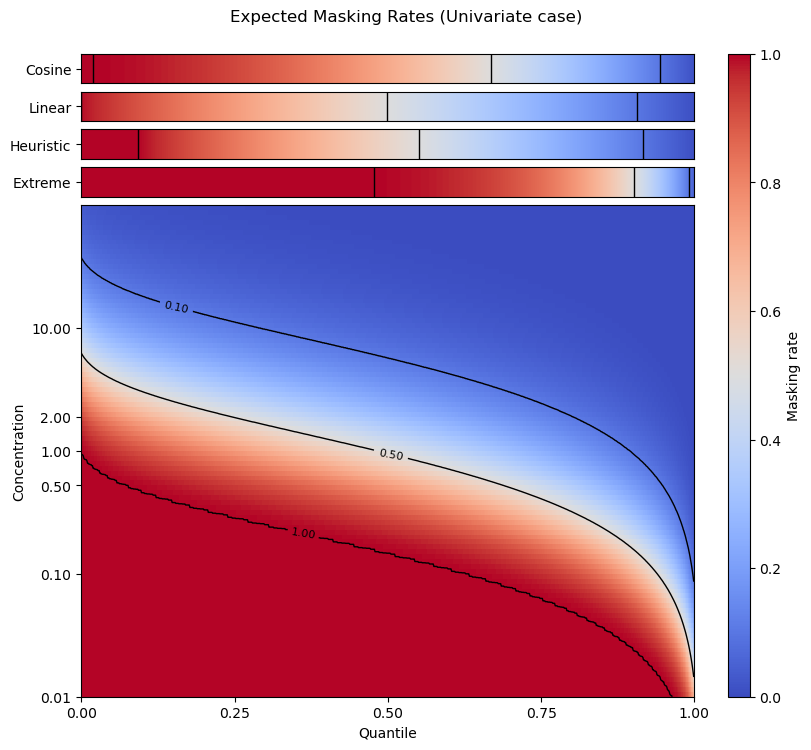

In [17]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
cs = 10**torch.linspace(-2,2,100)
u1, u2 = torch.meshgrid([u]*2, indexing='ij')
masks = torch.stack([u1 > StableKumaraswamy(c1=c1, c0=1).quantile(u2) for c1 in cs])
rates= (masks.float().mean(1))

r_cos = torch.cos((torch.pi / 2) * u2).mean(0, keepdim=True)
r_lin = (1 - u2).mean(0, keepdim=True)
p = 0.1
r_h = (1 - torch.where(u2 > p, (u2 - p) / (1 - p) , 0)).mean(0, keepdim=True)
r_k = (u1 > StableKumaraswamy(c1=0.16, c0=1).quantile(u2)).float().mean(0, keepdim=True)
# List of schedules to plot as bars
bars_to_plot = [
    ("Cosine", (r_cos)),
    ("Linear", (r_lin)),
    ("Heuristic", (r_h)),
    ("Extreme", (r_k))
]

lev = [0.1, 0.5, 0.999]
yticks = [0.01, 0.1, 0.5, 1, 2, 10]
cmap = 'coolwarm'
num_bars = len(bars_to_plot)
fig, axes = plt.subplots(
    num_bars + 1, 1, 
    figsize=(8, 5 + (0.5 * num_bars)), 
    sharex=True, 
    layout='constrained',
    gridspec_kw={'height_ratios': [0.06] * num_bars + [1]}
)

# Separate the bar axes from the main mesh axis
bar_axes = axes[:-1]
ax_main = axes[-1]

for i, (label, r_tensor) in enumerate(bars_to_plot):
    ax = bar_axes[i]
    ax.imshow(
        r_tensor, 
        cmap=cmap, 
        aspect='auto', 
        vmin=rates.min(), 
        vmax=rates.max()
    )

    for l in lev:
        v_idx = torch.argmin(torch.abs(r_tensor.flatten() - l)).item()
        ax.axvline(v_idx, color='black', linewidth=1)
        
    ax.set_yticks([0])
    ax.set_yticklabels([label])
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

m = ax_main.pcolormesh(rates, cmap=cmap)
c = ax_main.contour(rates, levels=lev, colors='black', linewidths=1)

fig.suptitle('Expected Masking Rates (Univariate case)', y=1.05)
ax_main.set_ylabel('Concentration')
ax_main.set_xlabel('Quantile')
ax_main.clabel(c, fmt={l: f'{l:.2f}' for l in lev}, inline=True, fontsize=8)

fig.colorbar(m, ax=axes.tolist(), label='Masking rate', pad=0.03, aspect=30)

u_ticks = torch.linspace(0, len(u), 5)
ax_main.set_xticks(u_ticks)
ax_main.set_xticklabels([f'{x:.2f}' for x in torch.linspace(0, 1, 5)])

y_indices = torch.searchsorted(cs, torch.tensor(yticks))
ax_main.set_yticks(y_indices)
ax_main.set_yticklabels([f'{y:.2f}' for y in yticks])

plt.savefig('univariate_masking_rates.png')
plt.show()

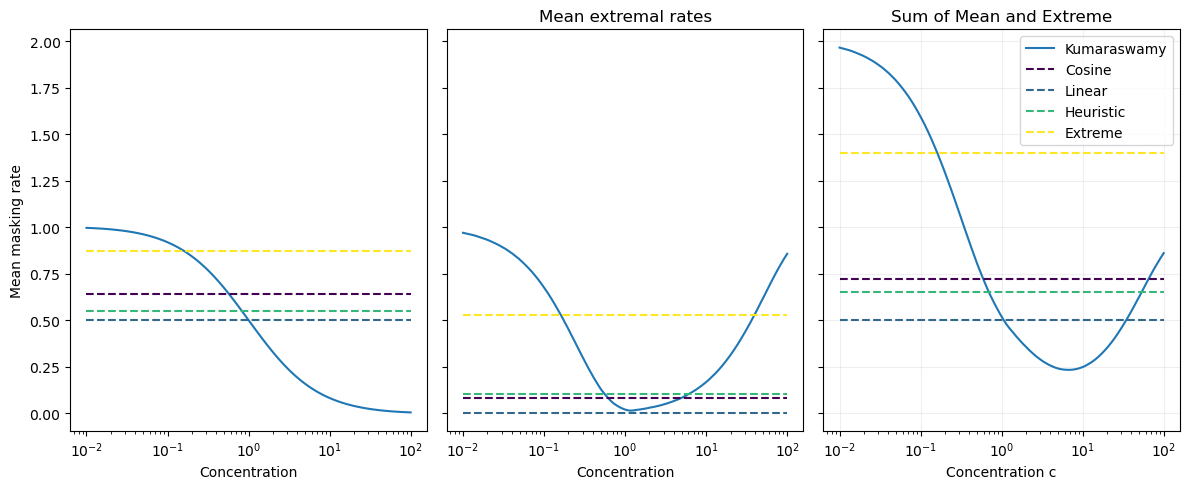

In [23]:
fig, axs = plt.subplots(1,3,figsize=(12,5), sharey=True, sharex=True)
plt.sca(axs[0])
plt.plot(cs, rates.mean(1), label = 'Kumaraswamy')
barcs = cm.viridis(torch.linspace(0, 1, len(bars_to_plot)))
for i, b in enumerate(bars_to_plot):
    plt.hlines(b[1].mean(), cs[0], cs[-1], colors=barcs[i], linestyles='dashed', label=b[0])
plt.xscale('log')
plt.xlabel('Concentration')
plt.ylabel('Mean masking rate')

plt.sca(axs[1])
extreme_rates = masks.float().mean(1) # (concentration, quantile)
extreme_rates = torch.logical_or(extreme_rates > 0.99, extreme_rates < 0.01).float().mean(1)
bextremes = [torch.logical_or(b[1] > 0.99, b[1] < 0.01).float().mean(1) for b in bars_to_plot]

plt.plot(cs, extreme_rates, label='Kumaraswamy')
for i, b in enumerate(bars_to_plot):
    plt.hlines(bextremes[i], cs[0], cs[-1], colors=barcs[i], linestyles='dashed', label=b[0])
plt.xscale('log')
plt.xlabel('Concentration')
plt.title('Mean extremal rates')
plt.sca(axs[2])

plt.plot(cs, extreme_rates + rates.mean(1), '-', label='Kumaraswamy')
# add bars for other schedules
barcs = cm.viridis(torch.linspace(0, 1, len(bars_to_plot)))
for i, b in enumerate(bars_to_plot):
    bmes = b[1].mean().item()
    bdes = bextremes[i].item()
    plt.hlines(bmes + bdes, cs[0], cs[-1], colors=barcs[i], linestyles='dashed', label=b[0])

plt.xscale('log')
plt.xlabel('Concentration c')
plt.title('Sum of Mean and Extreme')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


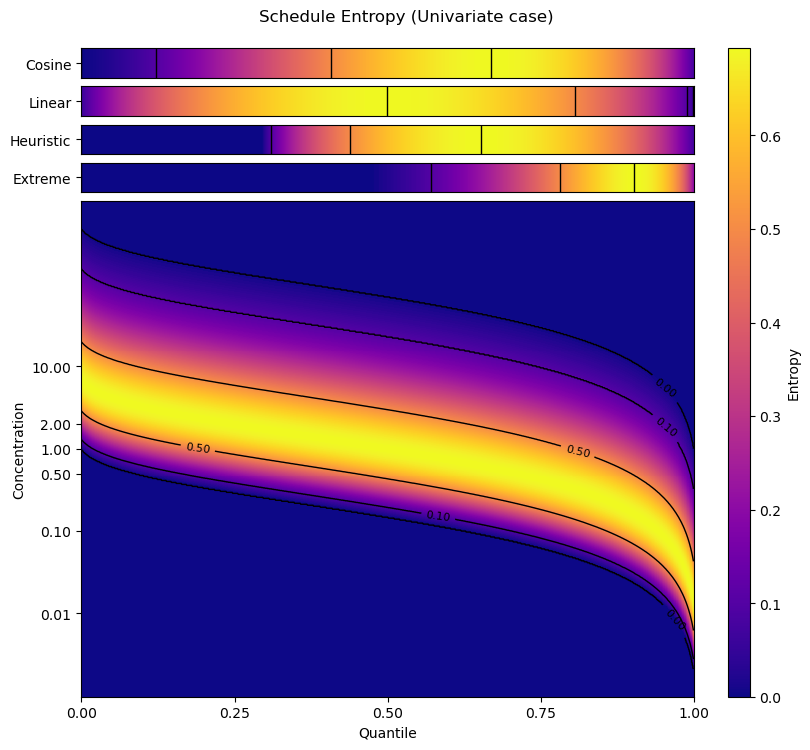

In [7]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
eps = 1e-6
entropy = lambda p:-(p * torch.log(p + eps) + (1 - p) * torch.log(1 - p + eps))

cs = 10**torch.linspace(-3,3,500)
u1, u2 = torch.meshgrid([u]*2, indexing='ij')
masks = torch.stack([u1 > StableKumaraswamy(c1=c1, c0=1).quantile(u2) for c1 in cs])
mask_entropy= entropy(masks.float().mean(1))

r_cos = torch.cos((torch.pi / 2) * u2).mean(0, keepdim=True)
r_lin = (1 - u2).mean(0, keepdim=True)
p = 0.3
r_h = (1 - torch.where(u2 > p, (u2 - p) / (1 - p) , 0)).mean(0, keepdim=True)
r_k = (u1 > StableKumaraswamy(c1=0.16, c0=1).quantile(u2)).float().mean(0, keepdim=True)
# List of schedules to plot as bars
bars_to_plot = [
    ("Cosine", entropy(r_cos)),
    ("Linear", entropy(r_lin)),
    ("Heuristic", entropy(r_h)),
    ("Extreme", entropy(r_k))
]

lev = [0.0, 0.1, 0.5, 0.999]
yticks = [0.01, 0.1, 0.5, 1, 2, 10]
cmap = 'plasma'
num_bars = len(bars_to_plot)

fig, axes = plt.subplots(
    num_bars + 1, 1, 
    figsize=(8, 5 + (0.5 * num_bars)), 
    sharex=True, 
    layout='constrained',
    gridspec_kw={'height_ratios': [0.06] * num_bars + [1]}
)

# Separate the bar axes from the main mesh axis
bar_axes = axes[:-1]
ax_main = axes[-1]

for i, (label, r_tensor) in enumerate(bars_to_plot):
    ax = bar_axes[i]
    ax.imshow(
        r_tensor, 
        cmap=cmap, 
        aspect='auto', 
        vmin=mask_entropy.min(), 
        vmax=mask_entropy.max()
    )

    for l in lev:
        v_idx = torch.argmin(torch.abs(r_tensor.flatten() - l)).item()
        ax.axvline(v_idx, color='black', linewidth=1)
        
    ax.set_yticks([0])
    ax.set_yticklabels([label])
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

m = ax_main.pcolormesh(mask_entropy, cmap=cmap)
c = ax_main.contour(mask_entropy, levels=lev, colors='black', linewidths=1)

fig.suptitle('Schedule Entropy (Univariate case)', y=1.05)
ax_main.set_ylabel('Concentration')
ax_main.set_xlabel('Quantile')
ax_main.clabel(c, fmt={l: f'{l:.2f}' for l in lev}, inline=True, fontsize=8)

fig.colorbar(m, ax=axes.tolist(), label='Entropy', pad=0.03, aspect=30)

u_ticks = torch.linspace(0, len(u), 5)
ax_main.set_xticks(u_ticks)
ax_main.set_xticklabels([f'{x:.2f}' for x in torch.linspace(0, 1, 5)])

y_indices = torch.searchsorted(cs, torch.tensor(yticks))
ax_main.set_yticks(y_indices)
ax_main.set_yticklabels([f'{y:.2f}' for y in yticks])

#plt.savefig('univariate_entropy.png')
plt.show()

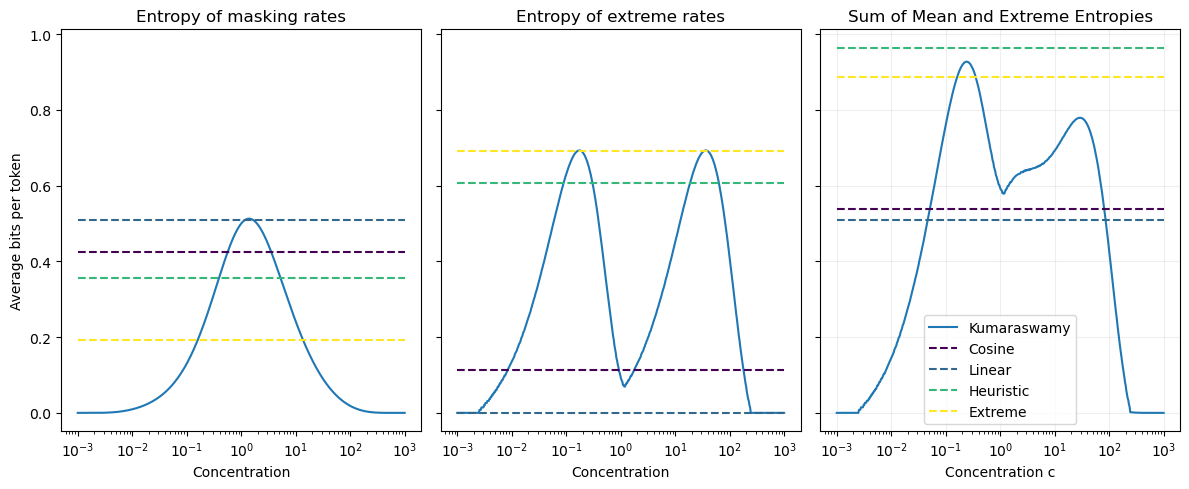

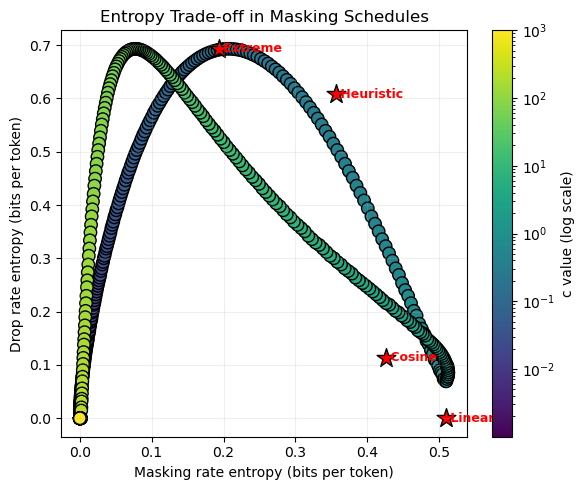

In [17]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
eps = 1e-6
entropy = lambda p:-(p * torch.log(p + eps) + (1 - p) * torch.log(1 - p + eps))

cs = 10**torch.linspace(-3,3,500)
u1, u2 = torch.meshgrid([u]*2, indexing='ij')
masks = torch.stack([u1 > StableKumaraswamy(c1=c1, c0=1).quantile(u2) for c1 in cs])
mask_rates = masks.float().mean(1)
mask_entropy= entropy(mask_rates)

r_cos = torch.cos((torch.pi / 2) * u2).mean(0, keepdim=True)
r_lin = (1 - u2).mean(0, keepdim=True)
p = 0.3
r_h = (1 - torch.where(u2 > p, (u2 - p) / (1 - p) , 0)).mean(0, keepdim=True)
r_k = (u1 > StableKumaraswamy(c1=0.16, c0=1).quantile(u2)).float().mean(0, keepdim=True)
# List of schedules to plot as bars
bars_to_plot = [
    ("Cosine", entropy(r_cos)),
    ("Linear", entropy(r_lin)),
    ("Heuristic", entropy(r_h)),
    ("Extreme", entropy(r_k))
]

lev = [0.0, 0.1, 0.5, 0.999]
yticks = [0.01, 0.1, 0.5, 1, 2, 10]
cmap = 'plasma'
num_bars = len(bars_to_plot)

fig, axs = plt.subplots(1,3,figsize=(12,5), sharey=True, sharex=True)
plt.sca(axs[0])
plt.plot(cs, mask_entropy.mean(1), label = 'Kumaraswamy')
barcs = cm.viridis(torch.linspace(0, 1, len(bars_to_plot)))
for i, b in enumerate(bars_to_plot):
    plt.hlines(b[1].mean(), cs[0], cs[-1], colors=barcs[i], linestyles='dashed', label=b[0])
plt.xscale('log')
plt.xlabel('Concentration')
plt.ylabel('Average bits per token')
plt.title('Entropy of masking rates')

plt.sca(axs[1])
extreme_rates = masks.float().mean(1) # (concentration, quantile)
extreme_rates = torch.logical_or(extreme_rates > 0.99, extreme_rates < 0.01).float()
extreme_entropy = entropy(extreme_rates.mean(1))

plt.plot(cs, extreme_entropy, label='Kumaraswamy')
for i, b in enumerate(bars_to_plot):
    bextreme = torch.logical_or(b[1] > 0.99, b[1] < 0.01).float().mean(1)
    plt.hlines(entropy(bextreme), cs[0], cs[-1], colors=barcs[i], linestyles='dashed', label=b[0])
plt.xscale('log')
plt.xlabel('Concentration')
plt.title('Entropy of extreme rates')
plt.sca(axs[2])

mes = torch.tensor([m.mean().item() for m in mask_entropy])
des = torch.tensor([d.item() for d in extreme_entropy])

plt.plot(cs, mes + des, '-', label='Kumaraswamy')
# add bars for other schedules
barcs = cm.viridis(torch.linspace(0, 1, len(bars_to_plot)))
for i, b in enumerate(bars_to_plot):
    bmes = b[1].mean().item()
    bdes = entropy(torch.logical_or(b[1] > 0.99, b[1] < 0.01).float().mean(1)).item()
    plt.hlines(bmes + bdes, cs[0], cs[-1], colors=barcs[i], linestyles='dashed', label=b[0])

plt.xscale('log')
plt.xlabel('Concentration c')
plt.title('Sum of Mean and Extreme Entropies')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
from matplotlib.colors import LogNorm


plt.figure(figsize=(6,5))

sc = plt.scatter(mes, des, c=cs, s=80, cmap='viridis', edgecolor='k', norm=LogNorm())

for i, b in enumerate(bars_to_plot):
    bmes = b[1].mean().item()
    bdes = entropy(torch.logical_or(b[1] > 0.99, b[1] < 0.01).float().mean(1)).item()
    plt.scatter(bmes, bdes, marker='*', s=200, color='red', edgecolor='k', label=b[0])
    plt.text(bmes, bdes, f' {b[0]}', fontsize=9, va='center', ha='left', color = 'red', weight ='bold')

plt.xlabel('Masking rate entropy (bits per token)')
plt.ylabel('Drop rate entropy (bits per token)')
plt.grid(True, alpha=0.2)
plt.title('Entropy Trade-off in Masking Schedules')

cbar = plt.colorbar(sc)
cbar.set_label('c value (log scale)' if cs.max()/cs.min() > 10 else 'c value')


plt.tight_layout()
plt.show()

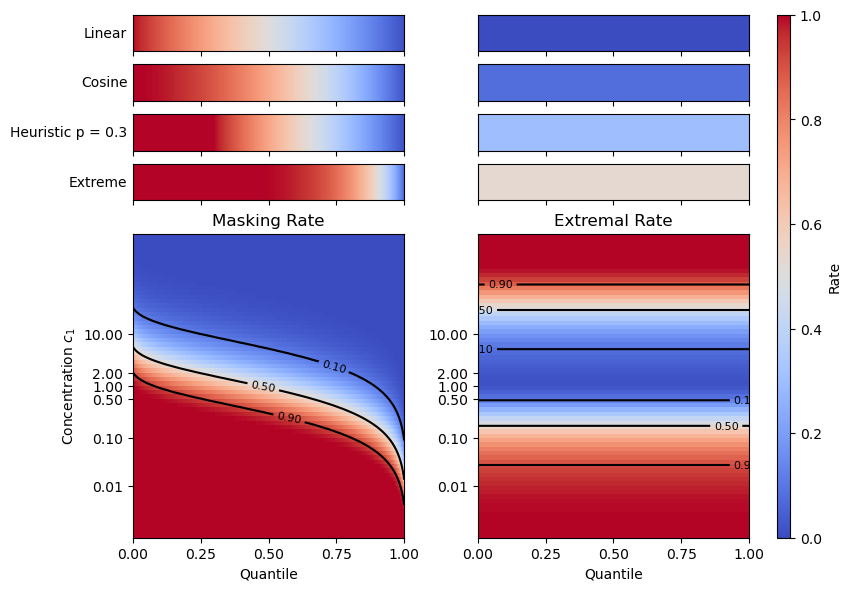

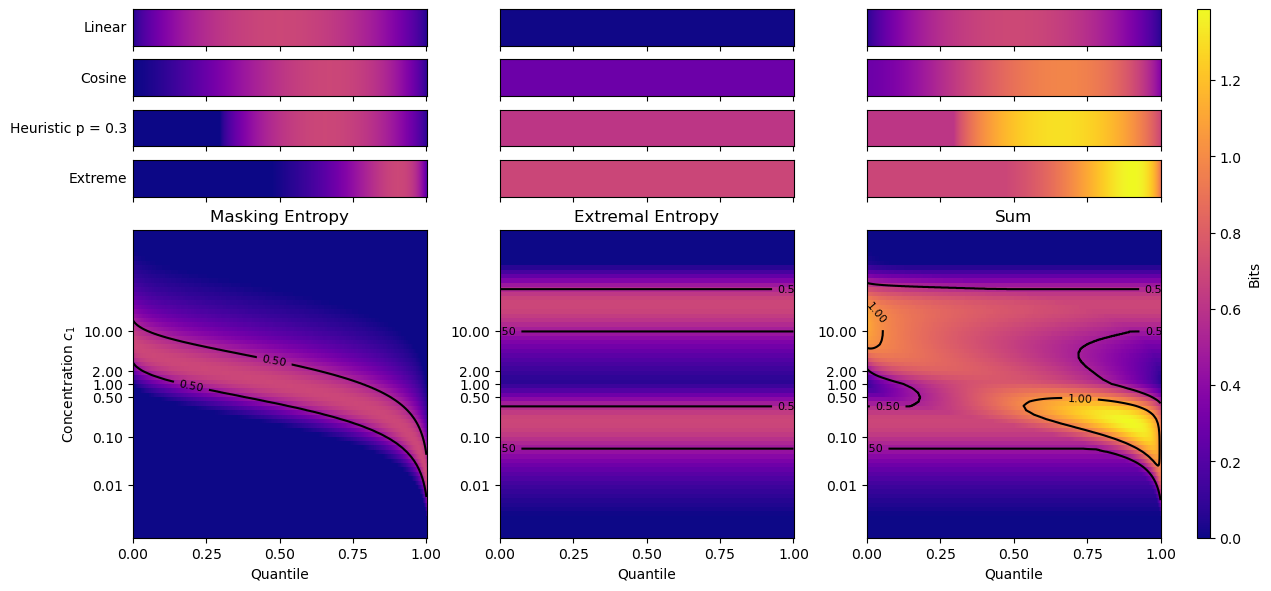

In [ ]:
p_h = 0.3
eps = 1e-6

u = torch.linspace(1e-2, 1 - 1e-2, 1000)
cs = 10 ** torch.linspace(-3, 3, 70)
u1, u2 = torch.meshgrid(u, u, indexing="ij")

entropy = lambda p: -(p * torch.log(p + eps) + (1 - p) * torch.log(1 - p + eps))

masks = torch.stack([
    u1 > StableKumaraswamy(c1=c1, c0=1).quantile(u2)
    for c1 in cs
])
rates = masks.float().mean(1)
ext_rates = (rates.gt(0.99) | rates.lt(0.01)).float().mean(1, keepdim=True)
ext_rates = ext_rates.expand_as(rates)

r_cos = torch.cos(torch.pi * 0.5 * u)[None]
r_lin = (1 - u)[None]
r_h = (1 - torch.where(u > p_h, (u - p_h) / (1 - p_h), 0))[None]
r_k = (u1 > StableKumaraswamy(c1=0.16, c0=1).quantile(u2)).float().mean(0, keepdim=True)

baselines = [
    ("Linear", r_lin),
    ("Cosine", r_cos),
    (f"Heuristic p = {p_h}", r_h),
    ("Extreme", r_k),
]

processed = []
for name, r in baselines:
    ext = (r.gt(0.99) | r.lt(0.01)).float().mean()
    ext = ext.expand_as(r)
    processed.append(dict(
        name=name,
        rate=r,
        ext_rate=ext,
        ent_rate=entropy(r),
        ent_ext=entropy(ext),
        ent_sum=entropy(r) + entropy(ext),
    ))

yticks_val = [0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
y_idx = torch.searchsorted(cs, torch.tensor(yticks_val))
x_idx = torch.linspace(0, len(u) - 1, 5)
x_lbl = [f"{x:.2f}" for x in torch.linspace(0, 1, 5)]

groups = [
    dict(
        title="Univariate Masking Rates",
        data=[rates, ext_rates],
        keys=["rate", "ext_rate"],
        subtitles=["Masking Rate", "Extremal Rate"],
        cmap="coolwarm",
        unit="Rate",
        levels=[0.1, 0.5, 0.9],
    ),
    dict(
        title="Schedule Entropy Analysis",
        data=[entropy(rates), entropy(ext_rates), entropy(rates) + entropy(ext_rates)],
        keys=["ent_rate", "ent_ext", "ent_sum"],
        subtitles=["Masking Entropy", "Extremal Entropy", "Sum"],
        cmap="plasma",
        unit="Bits",
        levels=[0.5, 1.0],
    ),
]

for g in groups:
    n_rows = len(processed) + 1
    n_cols = len(g["data"])

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4.2 * n_cols, 5.8),
        sharex=True,
        layout="constrained",
        gridspec_kw=dict(height_ratios=[0.12] * (n_rows - 1) + [1]),
    )

    vmin = min(d.min() for d in g["data"]).item()
    vmax = max(d.max() for d in g["data"]).item()
    levels = [l for l in g["levels"] if vmin < l < vmax]

    for j in range(n_cols):
        for i, b in enumerate(processed):
            ax = axes[i, j]
            ax.imshow(b[g["keys"][j]], cmap=g["cmap"], aspect="auto",
                      vmin=vmin, vmax=vmax)
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(b["name"], rotation=0, ha="right", va="center")

        ax = axes[-1, j]
        im = ax.pcolormesh(g["data"][j], cmap=g["cmap"],
                           vmin=vmin, vmax=vmax)
        if levels:
            c = ax.contour(g["data"][j], levels=levels,
                           colors="black", linewidths=1.5)
            ax.clabel(c, fmt="%.2f", fontsize=8, inline=True)

        ax.set_title(g["subtitles"][j], pad=6)
        ax.set_xticks(x_idx)
        ax.set_xticklabels(x_lbl)
        ax.set_yticks(y_idx)
        ax.set_yticklabels([f"{y:.2f}" for y in yticks_val])
        ax.set_xlabel("Quantile")
        if j == 0:
            ax.set_ylabel(r"Concentration $c_1$")

    fig.colorbar(im, ax=axes, label=g["unit"], aspect=40, pad=0.02)
    plt.show()
